In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from data_provider import read_prices, read_data

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, per_train=0.6, per_val = 0.5):
    p_train = int(len(X) * per_train)
    p_val = int((len(X) - p_train) * per_val)
    X_train = X[0:p_train]
    Y_train = y[0:p_train]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_val = X[p_train:p_val]
    Y_val = y[p_train:p_val]

    X_test = X[p_val:]
    Y_test = y[p_val:]

    return X_train, X_test, X_val, Y_val, Y_train, Y_test

In [29]:
market = 'BTC-USDT'
kline = '1h'
df   = read_data(market, kline)
closep = df.loc[:, 'C'].tolist()

data = df.as_matrix(['O','H', 'L', 'C', 'V'])

data[:,4] = data[:,4] +1 
data  = np.diff(np.log(data), axis = 0)

array([[10325.64    , 10421.      , 10240.      , 10410.      ,
         1500.318473],
       [10407.      , 10420.      , 10319.22    , 10418.      ,
          804.101924],
       [10420.      , 10464.99    , 10288.3     , 10331.      ,
          931.9551  ],
       ...,
       [ 7419.67    ,  7456.8     ,  7380.1     ,  7440.88    ,
         1060.433477],
       [ 7446.98    ,  7457.3     ,  7378.26    ,  7405.      ,
          999.492085],
       [ 7404.99    ,  7443.      ,  7403.15    ,  7440.      ,
          321.063376]])

In [20]:
data.shape

(2053, 5)

In [8]:
WINDOW = 30
EMB_SIZE = 5
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        data_win = data[i:i + WINDOW]
        data_norm = (data_win - np.mean(data_win, axis = 0))/np.std(data_win, axis = 0)

        y_i = closep[i + WINDOW + FORECAST]  
        X.append(data_win)
        Y.append(y_i)
    except Exception as e:
        break
        
X, Y = np.array(X), np.array(Y)
X_train, X_test, X_val, Y_val, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [9]:
model = Sequential()
model.add(Convolution1D(input_shape   = (WINDOW, EMB_SIZE),
                        filters       = 16,
                        kernel_size   = 4,
                        padding       = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters       = 8,
                        kernel_size   = 4,
                        padding       = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model.fit(X_train, Y_train, 
          epochs = 100, 
          batch_size = 32, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 1820 samples, validate on 203 samples
Epoch 1/100
1820/1820 [==============================] - 2s 1ms/step - loss: 0.8461 - acc: 0.4912 - val_loss: 0.6917 - val_acc: 0.5271

Epoch 00001: val_loss improved from inf to 0.69175, saving model to lolkek.hdf5
Epoch 2/100
1820/1820 [==============================] - 0s 153us/step - loss: 0.7654 - acc: 0.4978 - val_loss: 0.6910 - val_acc: 0.5320

Epoch 00002: val_loss improved from 0.69175 to 0.69099, saving model to lolkek.hdf5
Epoch 3/100
1820/1820 [==============================] - 0s 153us/step - loss: 0.7368 - acc: 0.5071 - val_loss: 0.6730 - val_acc: 0.5961

Epoch 00003: val_loss improved from 0.69099 to 0.67300, saving model to lolkek.hdf5
Epoch 4/100
1820/1820 [==============================] - 0s 153us/step - loss: 0.7205 - acc: 0.5165 - val_loss: 0.6846 - val_acc: 0.5665

Epoch 00004: val_loss did not improve from 0.67300
Epoch 5/100
1820/1820 [==============================] - 0s 153us/step - loss: 0.7166 - acc: 0.5088 - va

In [11]:
model.load_weights("lolkek.hdf5")
pred = model.predict(np.array(X_test))

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print (C / C.astype(np.float).sum(axis=1))


[[0.70652174 0.24324324]
 [0.23913043 0.8018018 ]]


In [16]:
from backtest import simulation
signals = np.argmax(pred, axis = 1)

init_data = {'exchange_commission': 0.001,
             'start_capital'     : 100,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999,
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1])

In [ ]:
df = simulation(ticks, signals, init_data)
print('days', round(len(ticks)/24))
print('trades', df[df['signal'] == -1].shape[0])
df;

[[0.90909091 0.11111111]
 [0.36363636 0.55555556]]


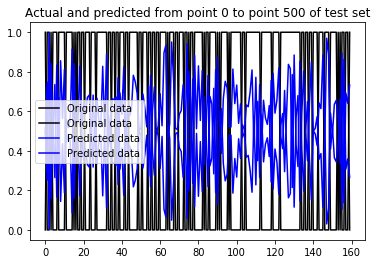

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print( C / C.astype(np.float).sum(axis=1))

FROM = 0
TO = FROM + 500

original = Y_test[FROM:TO]
predicted = pred[FROM:TO] 

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()